In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
# import s3fs
import re
from pelicanfs.core import PelicanFileSystem, PelicanMap,OSDFFileSystem 
import fsspec.implementations.http as fshttp
import geopandas as gpd
from pystac_client import Client
# from odc.stac import stac_load
from rasterio.mask import mask
import rasterio
from shapely.geometry import box

from shapely.geometry import mapping
from pyproj import CRS
from geopandas import GeoSeries

import stackstac

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client as dask_client
from dask.distributed import performance_report

### Use the GeoJSON file to get the Area of Interest and query the STAC catalog for items

In [3]:
# # Load the GeoJSON file
# geojson_path = '../../3100180240.geojson' 
# gdf = gpd.read_file(geojson_path)

# Display the loaded GeoDataFrame
# print(gdf)

In [4]:
# # Extract AOI geometry
# aoi_geometry = gdf.geometry.iloc[0]
# aoi_bounds   = aoi_geometry.bounds  # (minx, miny, maxx, maxy)

# # Get AOI centroid for visualization
# centroid  = aoi_geometry.centroid
# long, lat = centroid.x, centroid.y

# # Print the bounding box to verify
# print("Bounding Box:", aoi_bounds)

In [5]:
aoi_bounds = (134.66615966473387,  66.82737559988661, 134.72162967387277, 66.85380494758718)
long, lat = 134.70071475239416, 66.84143426792251

## New code

Here we start with [this tutorial](https://www.streambatch.io/knowledge/ndvi-from-sentinel-2-imagery-using-stac)

In [6]:
start_date      = "2020-06"
end_date        = "2020-09"

In [7]:
sentinel_search_url = "https://earth-search.aws.element84.com/v1"
sentinel_stac_client = Client.open(sentinel_search_url)
items = sentinel_stac_client.search(
       datetime=f"{start_date}/{end_date}",
       intersects=dict(type="Point", coordinates=(long, lat)),
       collections=["sentinel-2-l2a"]).item_collection()

## Stack your STAC

In [8]:
sentinel_stack = stackstac.stack(items, assets=["red", "nir", "scl"],
                          # bounds=[long-0.005, lat-0.005, long+0.005, lat+0.005],
                         bounds = aoi_bounds,
                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          epsg=4326,
                                 chunksize=(1, 1, 50, 50) # Original - many small chunks bad for plotting
                                 # chunksize=(1, -1, 100, 100)
                                ).rename(
       {'x': 'lon', 'y': 'lat'}).to_dataset(dim='band')

## Calculate NDVI

In [9]:
# If the denomenator is a zero it's a real pain
zero_mask = sentinel_stack['nir'] + sentinel_stack['red']
# sentinel_stack.where(zero_mask == 0, np.nan)

In [10]:
sentinel_stack['ndvi'] = (sentinel_stack.where(zero_mask != 0, np.nan)['nir'] - sentinel_stack.where(zero_mask != 0, np.nan)['red'])/\
                        (sentinel_stack.where(zero_mask != 0, np.nan)['nir'] + sentinel_stack.where(zero_mask != 0, np.nan)['red'])


sentinel_stack = sentinel_stack[['ndvi', 'scl']]
sentinel_stack = sentinel_stack.drop_vars([c for c in sentinel_stack.coords if not (c in ['time', 'lat', 'lon'])])
sentinel_stack

<xarray.Dataset> Size: 146MB
Dimensions:  (time: 140, lat: 285, lon: 229)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2020-06-02T02:39:04.253000 ... 2020-09...
  * lon      (lon) float64 2kB 134.7 134.7 134.7 134.7 ... 134.7 134.7 134.7
  * lat      (lat) float64 2kB 66.85 66.85 66.85 66.85 ... 66.83 66.83 66.83
Data variables:
    ndvi     (time, lat, lon) float64 73MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    scl      (time, lat, lon) float64 73MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(np.float64(134.665961102730...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 134.67|\n| 0.00,-0.00, 66.85|\n| 0.00, 0.00...
    resolution_xy:  (np.float64(0.00024386376594520698), np.float64(9.3026333...

## Test on the centroid

In [11]:
sentinel_point = sentinel_stack.interp(lat=lat, lon=long,
                                      method="nearest")

In [12]:
sentinel_point.load()

<xarray.Dataset> Size: 3kB
Dimensions:  (time: 140)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2020-06-02T02:39:04.253000 ... 2020-09...
    lat      float64 8B 66.84
    lon      float64 8B 134.7
Data variables:
    ndvi     (time) float64 1kB 0.5132 -0.4046 0.4256 ... 0.02815 0.3247 -0.1172
    scl      (time) float64 1kB 3.0 3.0 10.0 10.0 4.0 ... 5.0 9.0 9.0 3.0 3.0
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(np.float64(134.665961102730...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 134.67|\n| 0.00,-0.00, 66.85|\n| 0.00, 0.00...
    resolution_xy:  (np.float64(0.00024386376594520698), np.float64(9.3026333...

(-1.0, 5.0)

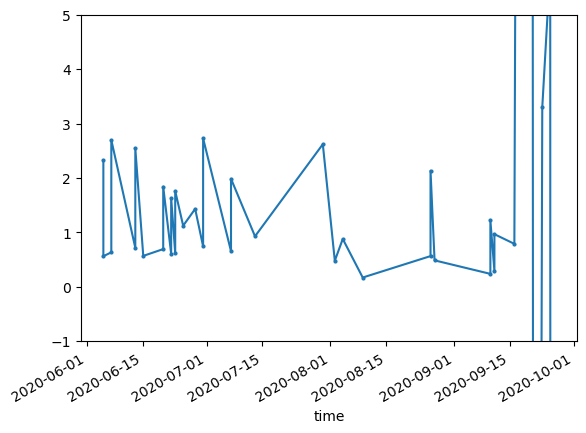

In [13]:
sentinel_table = sentinel_point.to_dataframe()
sentinel_table_filtered = sentinel_table[(sentinel_table['scl'] == 4) |
                                        (sentinel_table['scl'] == 5)]

fig, ax = plt.subplots()
sentinel_table_filtered['ndvi'].plot(label='unfiltered',
                                     marker='o', 
                                     # linestyle='--',
                                     markersize=2, ax=ax)
ax.set_ylim(-1.0,5.0)



Fascinating. What happened in late July, early August 2020? Let's take a look at an asset from the collection during that time period.

In [14]:
pics = {}
from datetime import datetime
for item in items:
    item_dict = {}
    item_dict['date'] = item.properties['datetime']
    item_dict['pic'] = item.assets['visual'].href
    item_dict['thumb'] = item.assets['thumbnail'].href
    pics[item.id] = item_dict

In [16]:
%%time
from rasterio.plot import show
with rasterio.open(pics['S2A_53WMQ_20200804_1_L2A']['pic']) as dataset:
    show(dataset)

RasterioIOError: '/vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/53/W/MQ/2020/8/S2A_53WMQ_20200804_1_L2A/TCI.tif' does not exist in the file system, and is not recognized as a supported dataset name.

That'll do it! (this is a fire burning the larch forests of the eastern Siberia taiga)

## Plot the whole stack?

### Mosaic by date

In [15]:
sentinel_stack_mosaicked = sentinel_stack.groupby('time.date').median(dim='time')
# sentinel_stack_mosaicked = sentinel_stack_mosaicked.rename({'date': 'time'})
# sentinel_stack_mosaicked['time'] = sentinel_stack_mosaicked['time'].astype('datetime64[ns]')


Day of year makes it easier for a linear trend analysis!

In [16]:
day_of_year = xr.DataArray(
    sentinel_stack_mosaicked['date'].astype('datetime64[ns]').dt.dayofyear,
    coords={'date': sentinel_stack_mosaicked['date']},
    dims='date',
    name='day_of_year'
)

sentinel_stack_mosaicked = sentinel_stack_mosaicked.assign_coords({"day_of_year": day_of_year})


Now we can look at cool pictures by date

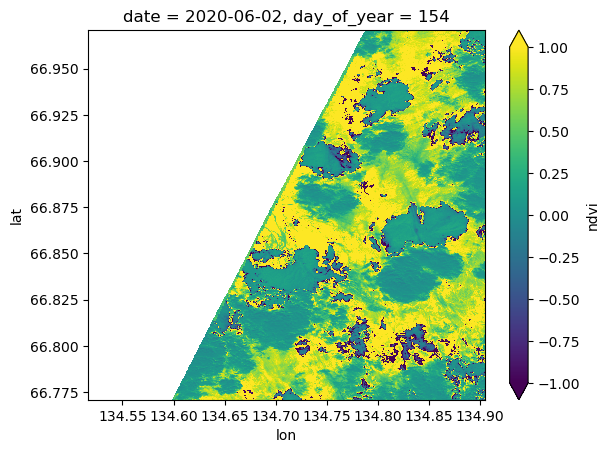

In [17]:
sentinel_stack_mosaicked['ndvi'][0].plot.imshow(vmin=-1.0, vmax=1.0)

### Mask out undesireable pixels in the stack according to the scene classification layer

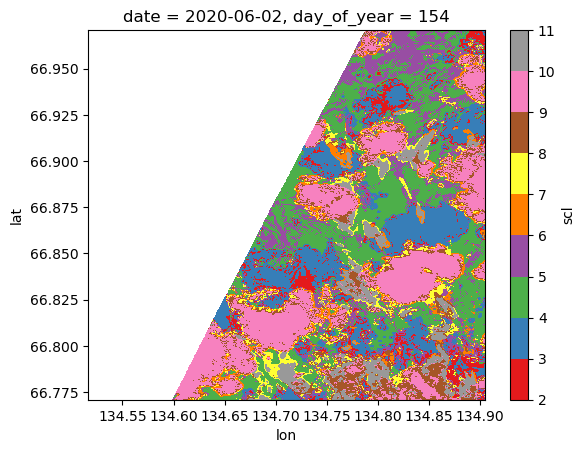

In [18]:
sentinel_stack_mosaicked['scl'][0].plot.imshow(cmap='Set1')

Google "sentinel 2 scene classification layer". You'll see that 4 and 5 are coded for vegetated and not vegetated. Conservatively, everything else is trash for interpreting NDVI.

In [43]:
ndvi_masked = sentinel_stack_mosaicked['ndvi'].where(
    sentinel_stack_mosaicked['scl'].isin([4, 5])
)

ndvi_masked = ndvi_masked.where(
    ndvi_masked >= -1.0
)

ndvi_masked = ndvi_masked.where(
    ndvi_masked <= 1.0
)

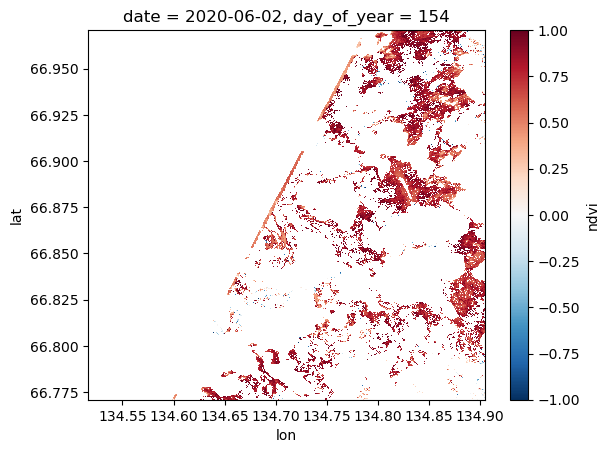

In [44]:
ndvi_masked[0].plot.imshow(
    # vmin=-1.0, vmax=1.0
)

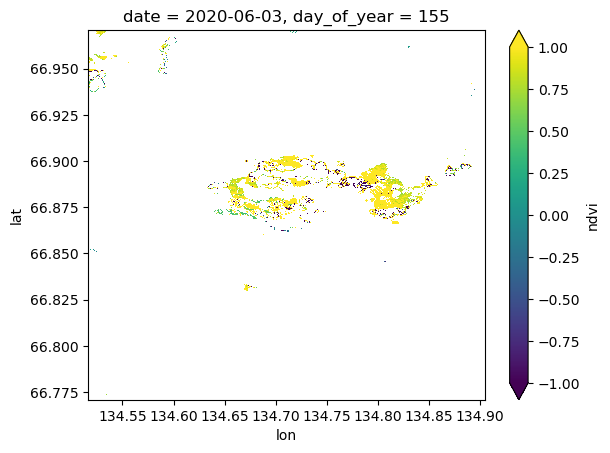

In [21]:
ndvi_masked[1].plot.imshow(vmin=-1.0, vmax=1.0)

Ah yes, that's better.

In [45]:
%%time
test = ndvi_masked[0].to_numpy()

CPU times: user 29.1 s, sys: 2.74 s, total: 31.8 s
Wall time: 28.7 s


In [46]:
np.nanmean(test)

np.float64(0.7366910371180113)

In [47]:
%%time
mean_ndvi_date = ndvi_masked.mean(dim=["lat", "lon"], skipna=True).to_dataframe(name="mean_ndvi").reset_index()
mean_ndvi_date

CPU times: user 32min 23s, sys: 3min 32s, total: 35min 55s
Wall time: 32min 48s


,date,day_of_year,mean_ndvi
0,2020-06-02,154,0.736691
1,2020-06-03,155,0.634121
2,2020-06-05,157,0.737199
3,2020-06-07,159,0.750108
4,2020-06-08,160,0.733238
...,...,...,...
67,2020-09-23,267,0.536568
68,2020-09-25,269,0.441684
69,2020-09-26,270,0.344097
70,2020-09-28,272,0.093649


<Axes: xlabel='day_of_year'>

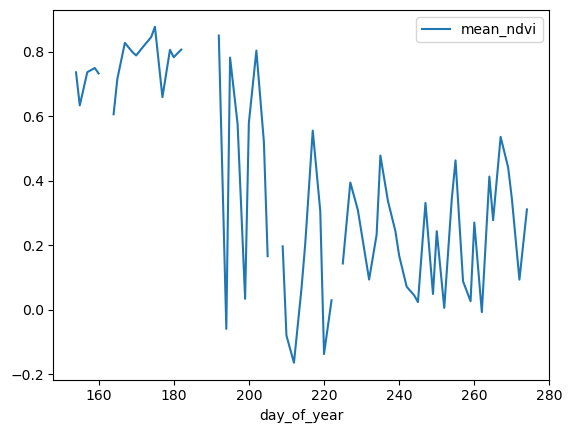

In [50]:
mean_ndvi_date.plot(x='day_of_year',y='mean_ndvi')

OK, cute. So detecting this somehow automatically and then cross-referencing this against some climate data would be cool (in this case it's burned, not climate, which are related but also maybe checking against some fire database or product too).

## Do a trendline fit

This takes FOREVER

In [ ]:
fit = ndvi_masked.polyfit(dim="day_of_year", deg=1)
slopes = fit["polyfit_coefficients"].sel(degree=1)
slopes

uh ok

In [ ]:
%%time
slopes.plot.imshow(vmin=-.1, vmax=.1)

In [ ]:

# Gotta give it a spatial dimension
slopes.rio.write_crs(ndvi_masked.rio.crs, inplace=True)

slopes.rio.to_raster("single_year_trend_test.tif")

In [ ]:
import pickle

# use the highest protocol (-1) because it is way faster than the default
# text based pickle format
pkl = pickle.dumps(slopes, protocol=-1)

In [ ]:
arr = slopes.to_numpy()